In [1]:
pip install torchviz

In [2]:
!pip install albumentations==0.4.6

In [3]:
import albumentations
import sys, os, random
import cv2 as cv
import torch
import torch.optim as optim
from datetime import datetime
from torchviz import make_dot
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, RGBShift, RandomScale, RandomGamma, NoOp, CLAHE, CenterCrop, GaussianBlur, OneOf, Resize, PadIfNeeded, HorizontalFlip, Normalize, ToGray, ShiftScaleRotate, RandomBrightnessContrast, HueSaturationValue

In [4]:
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [5]:
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [6]:
from Models.CapsuleNet import ResNetCapsule, CapsuleLoss
from Train.Train import Train
from Dataset.DFDC import DFDC
from Utils.Utils import gridshow, view_capsule_activation
from Eval.Eval import Eval

In [7]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [8]:
data_transforms = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [9]:
writer = SummaryWriter('/content/drive/MyDrive/Colab Notebooks/Tensorboard_Log/Pytorch_CapsuleResNet/'+str(datetime.now()))

In [10]:
train_image_datasets = DFDC(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDC(TESTING_DATA_FOLDER, data_transforms_test)

In [11]:
device = torch.device("cuda:0")
model = ResNetCapsule(random=True, dropout=0.05)

for param in model.CapsuleNet.parameters():
    param.requires_grad = True
criterion = CapsuleLoss()
optimizer = optim.Adam(model.CapsuleNet.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = Train(model, train_image_datasets, device, writer)
model, loader = model.run(criterion = criterion, optimizer = optimizer, scheduler = scheduler)

Epoch 1/10



train Loss: 2.8500 Acc: 0.6464



val Loss: 2.8208 Acc: 0.7171

Epoch 2/10



train Loss: 2.8128 Acc: 0.7261



val Loss: 2.8094 Acc: 0.7439

Epoch 3/10



train Loss: 2.7984 Acc: 0.7651



val Loss: 2.7834 Acc: 0.7878

Epoch 4/10



train Loss: 2.7813 Acc: 0.8089



val Loss: 2.7807 Acc: 0.7780

Epoch 5/10



train Loss: 2.7797 Acc: 0.8138



val Loss: 2.7749 Acc: 0.7927

Epoch 6/10



train Loss: 2.7762 Acc: 0.8192



val Loss: 2.7759 Acc: 0.7780

Epoch 7/10



train Loss: 2.7739 Acc: 0.8271



val Loss: 2.7746 Acc: 0.7927

Epoch 8/10



train Loss: 2.7748 Acc: 0.8211



val Loss: 2.7763 Acc: 0.7951

Epoch 9/10



train Loss: 2.7730 Acc: 0.8338



val Loss: 2.7754 Acc: 0.7927

Epoch 10/10



train Loss: 2.7731 Acc: 0.8235



val Loss: 2.7769 Acc: 0.7927

Training complete in 2m 52s
Best val Acc: 0.795122


In [12]:
eval = Eval(model,test_image_datasets,device)
eval.run()


F1 Score: 0.746031746031746
Log Loss: 0.6117888404987752
Confusion Matrix:
[[84 11]
 [37 60]]


In [13]:
summary(model.CapsuleNet.to(device), (256, 3, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 3, 3]         147,520
       BatchNorm2d-2             [-1, 64, 3, 3]             128
              ReLU-3             [-1, 64, 3, 3]               0
            Conv2d-4             [-1, 16, 3, 3]           9,232
       BatchNorm2d-5             [-1, 16, 3, 3]              32
              ReLU-6             [-1, 16, 3, 3]               0
          StatsNet-7                [-1, 2, 16]               0
            Conv1d-8                 [-1, 8, 8]              88
       BatchNorm1d-9                 [-1, 8, 8]              16
           Conv1d-10                 [-1, 1, 8]              25
      BatchNorm1d-11                 [-1, 1, 8]               2
             View-12                    [-1, 8]               0
           Conv2d-13             [-1, 64, 3, 3]         147,520
      BatchNorm2d-14             [-1, 6

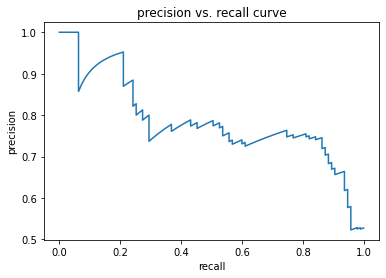

In [14]:
eval.plot_precisionrecall()

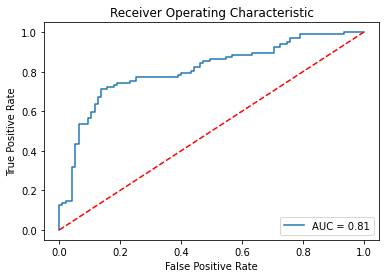

In [15]:
eval.plot_roc()